In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc
import gpplot as gpp 

gpp.set_aesthetics()

Comparing ability to recognize benign vs. pathogenic TP53 variants across technologies: Base Editing, Saturation Genome Editing, Prime Editing


Getting ClinVar Data, downloaded by Ellie Kaplan on 1/22/2025

In [60]:
clinvar=pd.read_csv("../../required_data/TP53/TP53_ClinVar_20250122.csv")
#subset to variants that pertain to amino acid changes in TP53
clinvar = clinvar[(clinvar['Gene(s)']=='TP53')&(clinvar['Variant type']=='single nucleotide variant')&(clinvar["Name"].str.count("p.")>0)].reset_index(drop=True)

#reformatting edit name
#retrieve amino acid edit from name
clinvar["Amino Acid Edit"]=clinvar.apply(lambda x: x["Name"].split("(p.")[1][:-1],axis=1)
#convert clinvar mutations so that a silent mutation indicates the amino acid name twice, not "="
clinvar["Original AA"]=clinvar["Amino Acid Edit"].str[:3]
clinvar["Amino Acid Edit"]=clinvar.apply(lambda x: x["Amino Acid Edit"].replace("=",x["Original AA"]),axis=1)

clinvar=clinvar[["Amino Acid Edit","Germline classification"]]
clinvar["Germline classification"].value_counts()

Germline classification
Uncertain significance                          588
Likely benign                                   460
Conflicting classifications of pathogenicity    439
Pathogenic                                      133
Pathogenic/Likely pathogenic                    118
Likely pathogenic                                39
Benign                                           33
Benign/Likely benign                             30
not provided                                      1
Name: count, dtype: int64

In [61]:
clinvar_pathogenic_mutations= clinvar[clinvar["Germline classification"].isin(["Pathogenic","Pathogenic/Likely pathogenic","Likely pathogenic"])]["Amino Acid Edit"].tolist()
clinvar_benign_mutations= clinvar[clinvar["Germline classification"].isin(["Benign","Benign/Likely benign","Likely benign"])]["Amino Acid Edit"].tolist()


In [62]:
# For general usage: Convert Amino Acid notation to 3-letter 
AA_convert= {"A":"Ala",
             "R":"Arg",
             "N":"Asn",
             "D":"Asp",
             "B":"Asx",
             "C":"Cys",
             "E":"Glu",
             "Q":"Gln",
             "Z":"Glx",
             "G":"Gly",
             "H":"His",
             "I":"Ile",
             "L":"Leu",
             "K":"Lys",
             "M":"Met",
             "F":"Phe",
             "P":"Pro",
             "S":"Ser",
             "T":"Thr",
             "W":"Trp",
             "Y":"Tyr",
             "V":"Val",
             "*":"Ter"}

# Part I: Interpreting effect size in presence vs. activity-based selection

Wranging internal data

In [80]:
# Get TP53 Tiling BE Z-scores for Etoposide Arm
ABE_presence= pd.read_excel("../../required_data/TP53/ABE_presence_zscores.xlsx",sheet_name="Sheet1",usecols=["sgRNA Target Sequence","Eto_RepAB_D21;z-score"])
ABE_activity= pd.read_excel("../../required_data/TP53/ABE_activity_zscores.xlsx",sheet_name="Sheet1",usecols=["sgRNA Target Sequence","Eto_RepAB_D21;z-score"])
CBE_presence= pd.read_excel("../../required_data/TP53/CBE_presence_zscores.xlsx",sheet_name="Sheet1",usecols=["sgRNA Target Sequence","Eto_RepAB_D21;z-score"])
CBE_activity= pd.read_excel("../../required_data/TP53/CBE_activity_zscores.xlsx",sheet_name="Sheet1",usecols=["sgRNA Target Sequence","Eto_RepAB_D21;z-score"])

Associating BE guides with Pathogenic variants. A guide is associated with pathogenecity if any of the edits introduced by the guide are pathogenic 

In [81]:
#predicted edits introduced by each guide if we assume that editing is restricted to the 4-8 window 
beagle_4_8=pd.read_table("../../required_data/TP53/TP53-NGN-codons_BEAGLE.txt",usecols=["Amino Acid Edit","Edit Type","sgRNA Target Sequence","Mutation Category"])

#stratify ABE vs CBE 
beagle_4_8_ABE=beagle_4_8[beagle_4_8["Edit Type"]=="A-G"].reset_index(drop=True)
beagle_4_8_CBE= beagle_4_8[beagle_4_8["Edit Type"]=="C-T"].reset_index(drop=True)

ABE_pathogenic_guides= beagle_4_8_ABE[beagle_4_8_ABE["Amino Acid Edit"].isin(clinvar_pathogenic_mutations)]["sgRNA Target Sequence"].tolist()
CBE_pathogenic_guides= beagle_4_8_CBE[beagle_4_8_CBE["Amino Acid Edit"].isin(clinvar_pathogenic_mutations)]["sgRNA Target Sequence"].tolist()


A guide is considered to be associated with Benign variants if it does not introduce any nonsense or missense (unless characterized as benign) mutations in the 3 to 9 window

In [82]:
beagle_3_9_ABE=pd.read_table("../../required_data/TP53/tp53_ABE_3_9-codons.txt",usecols=["Amino Acid Edit","Edit Type","sgRNA Sequence","Mutation Category"])
beagle_3_9_CBE=pd.read_table("../../required_data/TP53/tp53_CBE_3_9-codons.txt",usecols=["Amino Acid Edit","Edit Type","sgRNA Sequence","Mutation Category"])

#Exclude guides that introduce missense/nonsense mutations in 3-9 window that are not benign
ABE_nonbenign_nonsilent_guides=beagle_3_9_ABE[(beagle_3_9_ABE["Amino Acid Edit"].isin(clinvar_benign_mutations)==False)&(beagle_3_9_ABE["Mutation Category"]!="Silent")]["sgRNA Sequence"].tolist()
CBE_nonbenign_nonsilent_guides=beagle_3_9_CBE[(beagle_3_9_CBE["Amino Acid Edit"].isin(clinvar_benign_mutations)==False)&(beagle_3_9_CBE["Mutation Category"]!="Silent")]["sgRNA Sequence"].tolist()

ABE_benign_guides=beagle_3_9_ABE[beagle_3_9_ABE["sgRNA Sequence"].isin(ABE_nonbenign_nonsilent_guides)==False]["sgRNA Sequence"].tolist()
CBE_benign_guides=beagle_3_9_CBE[beagle_3_9_CBE["sgRNA Sequence"].isin(CBE_nonbenign_nonsilent_guides)==False]["sgRNA Sequence"].tolist()


In [83]:
beagle_3_9_ABE[beagle_3_9_ABE["sgRNA Sequence"].isin(ABE_nonbenign_nonsilent_guides)==False]

,Edit Type,sgRNA Sequence,Amino Acid Edit,Mutation Category
26,A-G,ACTCATGTTCAAGACAGAAG,Met384Val,Missense
27,A-G,AACTCATGTTCAAGACAGAA,Met384Val,Missense
28,A-G,AAACTCATGTTCAAGACAGA,Lys382Lys,Silent
29,A-G,AAACTCATGTTCAAGACAGA,Met384Val,Missense
50,A-G,AGTTTTTTATGGCGGGAGGT,His380His,Silent
...,...,...,...,...
1171,A-G,AAATCATCCATTGCTTGGGA,Asp41Asp,Silent
1172,A-G,AAATCATCCATTGCTTGGGA,Asp42Asp,Silent
1251,A-G,TTGTTTTCAGGAAGTCTGAA,Pro27Pro,Silent
1279,A-G,GACCTATGGAAACTGTGAGT,Leu22Leu,Silent


In [84]:
#subset for pathogenic, benign mutations 
ABE_presence_pathogenic=ABE_presence[ABE_presence["sgRNA Target Sequence"].isin(ABE_pathogenic_guides)].reset_index(drop=True)
CBE_presence_pathogenic=CBE_presence[CBE_presence["sgRNA Target Sequence"].isin(CBE_pathogenic_guides)].reset_index(drop=True)
BE_presence_pathogenic=pd.concat([ABE_presence_pathogenic,CBE_presence_pathogenic])

ABE_activity_pathogenic=ABE_activity[ABE_activity["sgRNA Target Sequence"].isin(ABE_pathogenic_guides)].reset_index(drop=True)
CBE_activity_pathogenic=CBE_activity[CBE_activity["sgRNA Target Sequence"].isin(CBE_pathogenic_guides)].reset_index(drop=True)
BE_activity_pathogenic=pd.concat([ABE_activity_pathogenic,CBE_activity_pathogenic])

ABE_presence_benign=ABE_presence[ABE_presence["sgRNA Target Sequence"].isin(ABE_benign_guides)].reset_index(drop=True)
CBE_presence_benign=CBE_presence[CBE_presence["sgRNA Target Sequence"].isin(CBE_benign_guides)].reset_index(drop=True)
BE_presence_benign=pd.concat([ABE_presence_benign,CBE_presence_benign])

ABE_activity_benign=ABE_activity[ABE_activity["sgRNA Target Sequence"].isin(ABE_benign_guides)].reset_index(drop=True)
CBE_activity_benign=CBE_activity[CBE_activity["sgRNA Target Sequence"].isin(CBE_benign_guides)].reset_index(drop=True)
BE_activity_benign=pd.concat([ABE_activity_benign,CBE_activity_benign])


#report counts for table (is same for activity since they use the same library): 
print("# BE guides that introduce pathogenic variants:", len(BE_presence_pathogenic))
print("# BE guides that introduce pathogenic variants that have z<-2 (presence):", len(BE_presence_pathogenic[BE_presence_pathogenic["Eto_RepAB_D21;z-score"]<-2]))
print("# BE guides that introduce pathogenic variants that have z<-2 (activity):", len(BE_activity_pathogenic[BE_activity_pathogenic["Eto_RepAB_D21;z-score"]<-2]))
print("# BE guides that introduce pathogenic variants that have z<-5 (presence):", len(BE_presence_pathogenic[BE_presence_pathogenic["Eto_RepAB_D21;z-score"]<-5]))
print("# BE guides that introduce pathogenic variants that have z<-5 (activity):", len(BE_activity_pathogenic[BE_activity_pathogenic["Eto_RepAB_D21;z-score"]<-5]))

print("\n# BE guides that introduce benign variants:", len(BE_presence_benign))
print("# BE guides that introduce benign variants that have z<-2 (presence):", len(BE_presence_benign[BE_presence_benign["Eto_RepAB_D21;z-score"]<-2]))
print("# BE guides that introduce benign variants that have z<-2 (activity):", len(BE_activity_benign[BE_activity_benign["Eto_RepAB_D21;z-score"]<-2]))


# BE guides that introduce pathogenic variants: 129
# BE guides that introduce pathogenic variants that have z<-2 (presence): 88
# BE guides that introduce pathogenic variants that have z<-2 (activity): 92
# BE guides that introduce pathogenic variants that have z<-5 (presence): 55
# BE guides that introduce pathogenic variants that have z<-5 (activity): 67

# BE guides that introduce benign variants: 216
# BE guides that introduce benign variants that have z<-2 (presence): 11
# BE guides that introduce benign variants that have z<-2 (activity): 13


In [85]:
min_z=min(BE_presence_pathogenic["Eto_RepAB_D21;z-score"].min(),BE_activity_pathogenic["Eto_RepAB_D21;z-score"].min())
max_z=max(BE_presence_pathogenic["Eto_RepAB_D21;z-score"].max(),BE_activity_pathogenic["Eto_RepAB_D21;z-score"].max())

In [86]:
#test separation of benign, pathogenic at various z-score cutoffs 

cutoffs=[]
frac_pathogenic_presence=[]
frac_pathogenic_activity=[]
frac_benign_presence=[]
frac_benign_activity=[]

for test_vals in range(10*min_z.astype(int),10*max_z.astype(int),1):
    z=test_vals*.1
    cutoffs.append(z)
    frac_pathogenic_presence.append(len(BE_presence_pathogenic[BE_presence_pathogenic["Eto_RepAB_D21;z-score"]<z])/len(BE_presence_pathogenic))
    frac_pathogenic_activity.append(len(BE_activity_pathogenic[BE_activity_pathogenic["Eto_RepAB_D21;z-score"]<z])/len(BE_activity_pathogenic))
    frac_benign_presence.append(len(BE_presence_benign[BE_presence_benign["Eto_RepAB_D21;z-score"]<z])/len(BE_presence_benign))
    frac_benign_activity.append(len(BE_activity_benign[BE_activity_benign["Eto_RepAB_D21;z-score"]<z])/len(BE_activity_benign))
    

Text(0.5, 1.0, 'ClinVar variant identification by selection method')

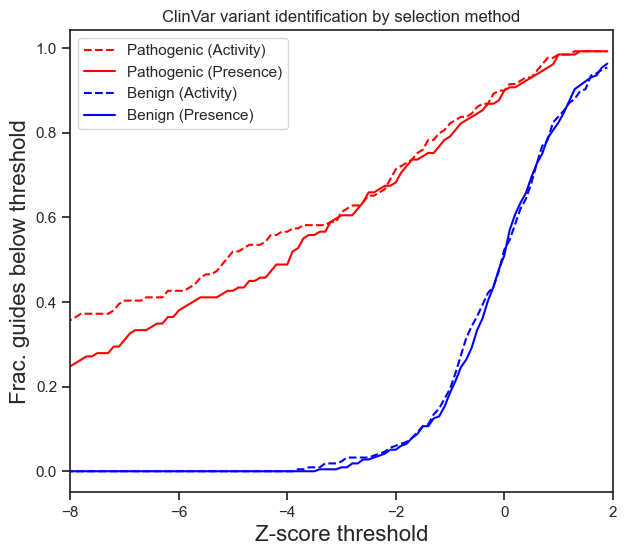

In [87]:
(fig,ax)=plt.subplots(figsize=(7,6))
BE_zscore_cutoffs_df=pd.DataFrame({"frac_pathogenic_presence":frac_pathogenic_presence,
              "frac_pathogenic_activity":frac_pathogenic_activity,
              "frac_benign_presence":frac_benign_presence,
              "frac_benign_activity":frac_benign_activity,
                                  "Z Score Cutoff":cutoffs
                                  })
plt.plot(BE_zscore_cutoffs_df["Z Score Cutoff"],BE_zscore_cutoffs_df["frac_pathogenic_activity"],label="Pathogenic (Activity)",c="red",linestyle="--")
plt.plot(BE_zscore_cutoffs_df["Z Score Cutoff"],BE_zscore_cutoffs_df["frac_pathogenic_presence"],label="Pathogenic (Presence)",c="red",linestyle="-")
plt.plot(BE_zscore_cutoffs_df["Z Score Cutoff"],BE_zscore_cutoffs_df["frac_benign_activity"],label="Benign (Activity)",c="blue",linestyle="--")
plt.plot(BE_zscore_cutoffs_df["Z Score Cutoff"],BE_zscore_cutoffs_df["frac_benign_presence"],label="Benign (Presence)",c="blue",linestyle="-")

plt.ylabel("Frac. guides below threshold",fontsize=16)
plt.xlabel("Z-score threshold",fontsize=16)

plt.legend(loc="upper left",title="")
plt.xlim(-8,2)

plt.title("ClinVar variant identification by selection method")
#gpp.savefig("tp53_BEtiling_effectsize_activity_presence_clinvar.pdf",bbox_inches="tight",dpi=600)

In [88]:
#Export sets of pathogenic ABE and CBE guides and their activity-based-selection Z-scores 
#Used for analysis of guides with high vs. low activity 
ABE_activity_benign.to_csv("../../required_data/TP53/ABE_benign_TP53_etoposide_activitybased_zscores.csv",index=False)
CBE_activity_benign.to_csv("../../required_data/TP53/CBE_benign_TP53_etoposide_activitybased_zscores.csv",index=False)


# Part II: Compare BE vs. Prime editing vs. ORF


Assess ability of BE vs. PE vs. ORF to separate guides that introduce pathogenic vs benign variants.    


### Prime editing: Gould

Cloned and edited https://github.com/samgould2/p53-prime-editing-sensor/blob/main/figure6.ipynb to export "merged" file. LFC reports Nutlin D34 vs D4 guide counts. Data filtered to only include guides with at least 10 sensor counts and at least 0%,10%, or 25% editing efficiency as suggested in the manuscript

In [89]:
PE_gould_nocutoff = pd.read_csv('../../required_data/TP53/PE_Gould_D34-D4_LFC_Nutlin_LD_no_editing_efficiency_filter.csv')
PE_gould_10cutoff = pd.read_csv('../../required_data/TP53/PE_Gould_D34-D4_LFC_Nutlin_LD_editing_efficiency_above_10.csv')
PE_gould_25cutoff = pd.read_csv('../../required_data/TP53/PE_Gould_D34-D4_LFC_Nutlin_LD_editing_efficiency_above_25.csv')

#convert edit notation to three-letter amino acids 
def convert_edit_notation(df):
    df["Original AA"]=df["HGVSp"].str[0].replace(AA_convert)
    df["AA Edit Pos"]=df["HGVSp"].str[1:-1]
    df["New AA"]=df["HGVSp"].str[-1].replace(AA_convert)
    df["Amino Acid Edit"]=df["Original AA"]+df["AA Edit Pos"]+df["New AA"]
    df=df[["peg_id","Amino Acid Edit","LFC"]]
    return df

PE_gould_nocutoff=convert_edit_notation(PE_gould_nocutoff)
PE_gould_10cutoff=convert_edit_notation(PE_gould_10cutoff)
PE_gould_25cutoff=convert_edit_notation(PE_gould_25cutoff)

In [90]:
PE_gould_pathogenic_nocutoff=PE_gould_nocutoff[PE_gould_nocutoff["Amino Acid Edit"].isin(clinvar_pathogenic_mutations)].reset_index(drop=True)
PE_gould_benign_nocutoff=PE_gould_nocutoff[PE_gould_nocutoff["Amino Acid Edit"].isin(clinvar_benign_mutations)].reset_index(drop=True)

PE_gould_pathogenic_10cutoff=PE_gould_10cutoff[PE_gould_10cutoff["Amino Acid Edit"].isin(clinvar_pathogenic_mutations)].reset_index(drop=True)
PE_gould_benign_10cutoff=PE_gould_10cutoff[PE_gould_10cutoff["Amino Acid Edit"].isin(clinvar_benign_mutations)].reset_index(drop=True)

PE_gould_pathogenic_25cutoff=PE_gould_25cutoff[PE_gould_25cutoff["Amino Acid Edit"].isin(clinvar_pathogenic_mutations)].reset_index(drop=True)
PE_gould_benign_25cutoff=PE_gould_25cutoff[PE_gould_25cutoff["Amino Acid Edit"].isin(clinvar_benign_mutations)].reset_index(drop=True)


### ORF: Giacomelli

Retrieving Giacomelli data from MaveDB. Scores are calculated as following: 

"Variant counts before and after selection are determined by Hiseq4000 which was further processed by ORFcall software. The logarithm (base 2) ratio of counts after and before selection is first calculated. This values is then normalized by all non-wildtype residues and synonymous variants. The Z scores are calculated by the averaged and standardized values between 2 replicates. This paper was using an older version of TP53 reference sequence, and we are depositing the result according to their published data."


In [91]:
#get ORF_giacomelli data (source: MaveDB https://mavedb.org/score-sets/urn:mavedb:00000068-a-1)
ORF_giacomelli=pd.read_csv("../../required_data/TP53/urn_mavedb_00000068-a-1_scores.csv")
ORF_giacomelli=ORF_giacomelli[ORF_giacomelli["score"].isna()==False].reset_index(drop=True)
ORF_giacomelli["Amino Acid Edit"]=ORF_giacomelli["hgvs_pro"].str[2:]
ORF_giacomelli=ORF_giacomelli[["Amino Acid Edit","score"]]
ORF_giacomelli

,Amino Acid Edit,score
0,Ter394Tyr,0.029980
1,Ter394Trp,0.062089
2,Ter394Val,-0.520054
3,Ter394Thr,-0.398481
4,Ter394Ser,-0.317579
...,...,...
8253,Met1Phe,0.151947
8254,Met1Glu,-0.604673
8255,Met1Asp,0.151947
8256,Met1Cys,-0.874059


In [92]:
ORF_giacomelli_pathogenic=ORF_giacomelli[ORF_giacomelli["Amino Acid Edit"].isin(clinvar_pathogenic_mutations)].reset_index(drop=True)
ORF_giacomelli_benign=ORF_giacomelli[ORF_giacomelli["Amino Acid Edit"].isin(clinvar_benign_mutations)].reset_index(drop=True)

print("# ORF guides that introduce ClinVar pathogenic mutations",len(ORF_giacomelli_pathogenic))
print("# ORF guides that introduce ClinVar benign mutations",len(ORF_giacomelli_benign))

# ORF guides that introduce ClinVar pathogenic mutations 264
# ORF guides that introduce ClinVar benign mutations 121


### ROC-AUC of BE, ORF, vs Prime Editing

In [93]:
def get_roc_df_and_auc(df,is_negative_selection,score_col_name):
    df["pos_ctl"]=df["level_0"]=="Pathogenic"
    df["neg_ctl"]=df["level_0"]=="Benign"
    df = df.sort_values(by = score_col_name,ascending=is_negative_selection).reset_index(drop=True)
    df['pos_ctl_cumsum'] = np.cumsum(df['pos_ctl'])
    df['neg_ctl_cumsum'] = np.cumsum(df['neg_ctl'])
    df['tpr'] = df['pos_ctl_cumsum']/(df['pos_ctl_cumsum'].iloc[-1])
    df['fpr'] = df['neg_ctl_cumsum']/(df['neg_ctl_cumsum'].iloc[-1])
    
    roc_df=df[["tpr","fpr"]]
    roc_auc=auc(roc_df['fpr'],roc_df['tpr'])
    return(roc_df,roc_auc)

In [97]:
# BE uses etoposide, so true positives have lower z-scores
BE_roc_df= pd.concat([BE_activity_pathogenic,BE_activity_benign],keys=["Pathogenic","Benign"]).reset_index()
(BE_roc_df,BE_roc_auc)=get_roc_df_and_auc(BE_roc_df,is_negative_selection=True, score_col_name="Eto_RepAB_D21;z-score")

# PE and ORF use Nutlin, so true positives have higher z-scores
PE_roc_df= pd.concat([PE_gould_pathogenic_nocutoff,PE_gould_benign_nocutoff],keys=["Pathogenic","Benign"]).reset_index()
(PE_roc_df,PE_roc_auc)=get_roc_df_and_auc(PE_roc_df,is_negative_selection=False, score_col_name="LFC")

PE_10_roc_df= pd.concat([PE_gould_pathogenic_10cutoff,PE_gould_benign_10cutoff],keys=["Pathogenic","Benign"]).reset_index()
(PE_10_roc_df,PE_10_roc_auc)=get_roc_df_and_auc(PE_10_roc_df,is_negative_selection=False, score_col_name="LFC")

PE_25_roc_df= pd.concat([PE_gould_pathogenic_25cutoff,PE_gould_benign_25cutoff],keys=["Pathogenic","Benign"]).reset_index()
(PE_25_roc_df,PE_25_roc_auc)=get_roc_df_and_auc(PE_25_roc_df,is_negative_selection=False, score_col_name="LFC")

ORF_roc_df=pd.concat([ORF_giacomelli_pathogenic,ORF_giacomelli_benign],keys=["Pathogenic","Benign"]).reset_index()
(ORF_roc_df,ORF_roc_auc)=get_roc_df_and_auc(ORF_roc_df,is_negative_selection=False, score_col_name="score")


In [95]:
guide_counts_df= pd.DataFrame(index=["# Pathogenic guides","# Benign guides"],data={"SGE":[len(ORF_giacomelli_pathogenic),
                                                                                           len(ORF_giacomelli_benign)],
                                                                                    "PE":[len(PE_gould_pathogenic_nocutoff),
                                                                                          len(PE_gould_benign_nocutoff)],
                                                                                    "PE, editing efficiency >10%":[len(PE_gould_pathogenic_10cutoff),
                                                                                          len(PE_gould_benign_10cutoff)],
                                                                                    "PE, editing efficiency >25%":[len(PE_gould_pathogenic_25cutoff),
                                                                                          len(PE_gould_benign_25cutoff)],
                                                                                    "BE":[len(BE_presence_pathogenic),
                                                                                          len(BE_presence_benign)]})
#guide_counts_df.to_csv("guide_counts_ROC_plot.csv")
guide_counts_df

,SGE,PE,"PE, editing efficiency >10%","PE, editing efficiency >25%",BE
# Pathogenic guides,264,4054,618,279,129
# Benign guides,121,1415,125,58,216


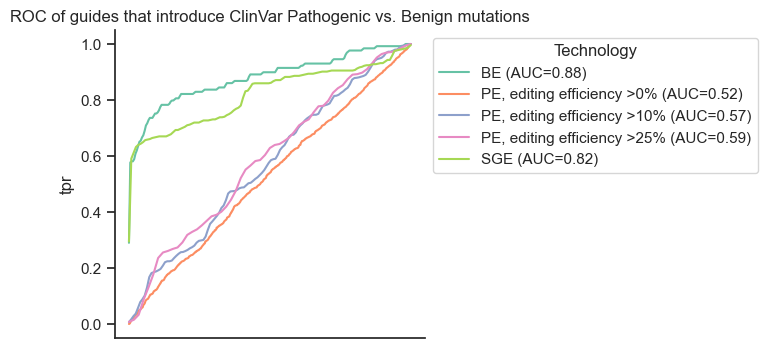

In [98]:
BE_label="BE (AUC="+str(round(BE_roc_auc,2))+")"
PE_label="PE, editing efficiency >0% (AUC="+str(round(PE_roc_auc,2))+")"
PE_10_label="PE, editing efficiency >10% (AUC="+str(round(PE_10_roc_auc,2))+")"
PE_25_label="PE, editing efficiency >25% (AUC="+str(round(PE_25_roc_auc,2))+")"
ORF_label="SGE (AUC="+str(round(ORF_roc_auc,2))+")"
roc_df=pd.concat([BE_roc_df,PE_roc_df,PE_10_roc_df,PE_25_roc_df,ORF_roc_df],keys=[BE_label,PE_label,PE_10_label,PE_25_label,ORF_label]).reset_index()

plt.subplots(figsize=(4, 4))
sns.lineplot(data=roc_df, x='fpr',
             y='tpr', hue="level_0",errorbar=None)
plt.title("ROC of guides that introduce ClinVar Pathogenic vs. Benign mutations")
plt.legend(bbox_to_anchor=(1,1),title="Technology")
sns.despine()
plt.xticks([])
plt.xlabel("")


#plt.savefig("PE_BE_ORF_ROC.pdf",bbox_inches="tight",dpi=600)
